This notebook is used to play around with an Hadoop environment. Firstly, I will extract data from a website, show some statistics and some plots. Next I will create a CSV and create a MapReduce script to play with the data.

In [202]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import platform
platform.python_version()

'3.6.1'

## Extracting the data
Credit to http://videogamecritic.com/nes.htm for making a nice list to work with.

In [2]:
import lxml.html
import requests

In [3]:
URL = 'http://videogamecritic.com/nes.htm'
resp = requests.get(URL)
if resp.status_code != 200:
        raise Exception('GET '+link+' {}'.format(resp.status_code))
data = lxml.html.fromstring(resp.content)
gamepages = ['http://videogamecritic.com/' + game.get('href') for game in data.cssselect('h3 a')]
gamepages

['http://videogamecritic.com/nesaa.htm',
 'http://videogamecritic.com/nesbb.htm',
 'http://videogamecritic.com/nescc.htm',
 'http://videogamecritic.com/nesde.htm',
 'http://videogamecritic.com/nesfh.htm',
 'http://videogamecritic.com/nesil.htm',
 'http://videogamecritic.com/nesmn.htm',
 'http://videogamecritic.com/nesor.htm',
 'http://videogamecritic.com/nesss.htm',
 'http://videogamecritic.com/nestt.htm',
 'http://videogamecritic.com/nesuz.htm']

Note: I have a Docker container running with Selenium instead of installing all dependencies on my system. See [this page](https://hub.docker.com/r/selenium/standalone-chrome/).

In [4]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
driver = webdriver.Remote("http://66.70.222.43:4444/wd/hub", DesiredCapabilities.CHROME)

In [5]:
gamedata = []
for page in gamepages:
    # Retrieve the data
    driver.get(page)
    data = lxml.html.fromstring(driver.page_source)
    # Extract the fields
    grades = [elem.text_content() for elem in data.cssselect('div[class*=\'hdr\']')]
    names = [elem.text_content() for elem in data.cssselect('div[class*=\'hdl\']')]
    metadata = [elem.text_content() for elem in data.cssselect('div[class*=\'mdl\']')]
    votes = [elem.text_content() for elem in data.cssselect('div[class*=\'vote\']')]
    # Append to dataset
    gamedata += list(zip(names, votes, grades, metadata))


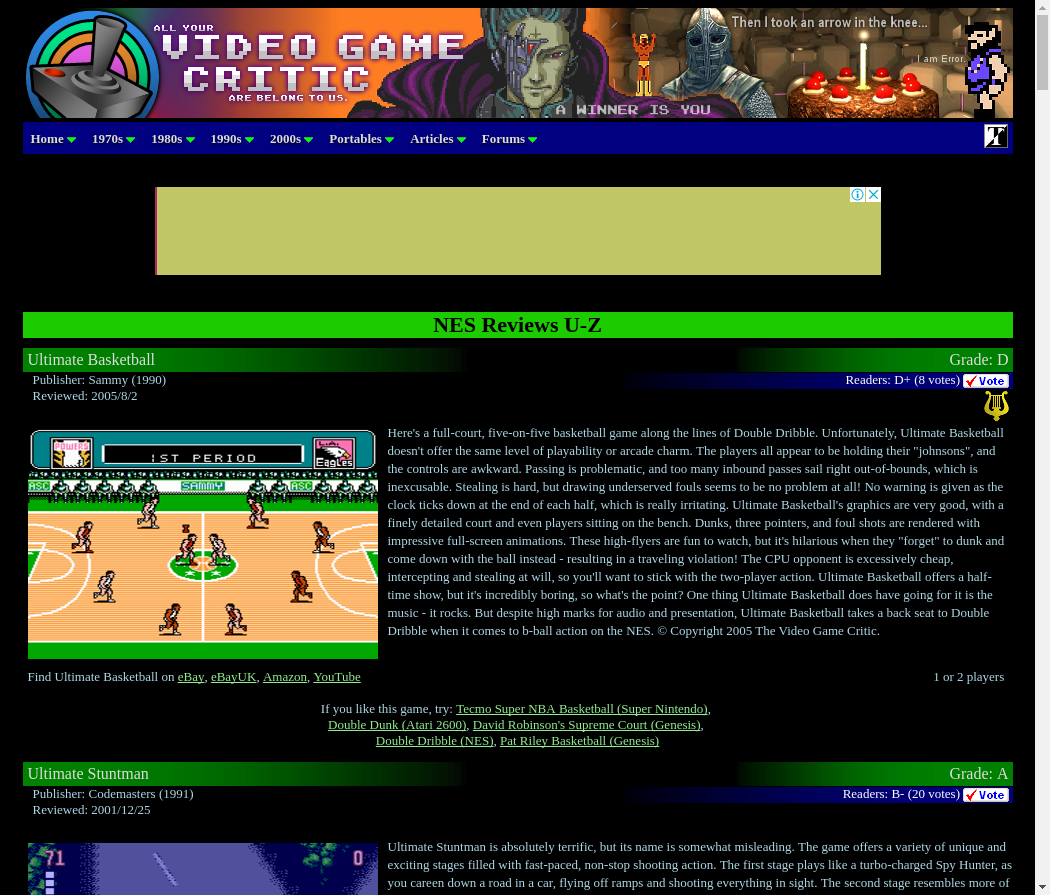

In [6]:
# Bonus: screenshot of the page
image = driver.get_screenshot_as_base64()
from IPython.display import HTML
HTML("""<img src="data:image/png;base64,{0}">""".format(image))

In [7]:
driver.quit()

## Cleaning the data

In [176]:
import pandas as pd

In [177]:
def map_rating(rating):
    """ Function to convert the rating to a number """
    if (rating == "A+"): return 1;
    if (rating == "A"): return 2;
    if (rating == "A-"): return 3;
    if (rating == "B+"): return 4;
    if (rating == "B"): return 5;
    if (rating == "B-"): return 6;
    if (rating == "C+"): return 7;
    if (rating == "C"): return 8;
    if (rating == "C-"): return 9;
    if (rating == "D+"): return 10;
    if (rating == "D"): return 11;
    if (rating == "D-"): return 12;
    if (rating == "F"): return 13;
    if (rating == "F-"): return 14;
    return 15;

In [178]:
df = pd.DataFrame.from_dict(gamedata)
df = df.rename(columns={0: "name", 1: "vote", 2: "grade", 3: "publisher"})

In [179]:
# Extract and convert data
df['reader_rating'] = df['vote'].str.extract('Readers:\s(.*?)\s\(', expand=True)
df['reader_rating']  = df['reader_rating'].apply(lambda x: map_rating(x)).astype('int')
df['number_of_votes'] = df['vote'].str.extract('\((\d*)\svotes\)', expand=True).astype('int')
df['grade'] = df['grade'].str.replace("Grade:", "").str.strip().apply(lambda x: map_rating(x)).astype('int')
df['publish_year'] = df['publisher'].str.extract('\((\d*)\)Reviewed', expand=True)
df['publisher'] = df['publisher'].str.extract("Publisher:\s(.*?)\s\(", expand=True)
df.drop('vote', axis=1, inplace=True)
# Calculate the total grade
df['total_grade'] = (df['grade'] + df['reader_rating']*df['number_of_votes']) / (df['number_of_votes']+1)
# Corrections
df['publisher'] = df['publisher'].str.replace('Electrobrain', 'Electro Brain')

In [180]:
df.dtypes

name                object
grade                int64
publisher           object
reader_rating        int64
number_of_votes      int64
publish_year        object
total_grade        float64
dtype: object

In [181]:
df.head()

,name,grade,publisher,reader_rating,number_of_votes,publish_year,total_grade
0,10-Yard Fight,12,Nintendo,10,44,1985,10.044444
1,1942,11,Capcom,8,65,1985,8.045455
2,1943,5,Capcom,4,58,1988,4.016949
3,720 Degrees,13,Tengen,11,24,1989,11.080000
4,8 Eyes,13,Taxan,10,30,1989,10.096774


## Calculate statistics

In [217]:
# The best game
df.loc[df['total_grade'].idxmin()]['name']

"Mike Tyson's Punch-Out!!"

In [218]:
# The worst game
df.loc[df['total_grade'].idxmax()]['name']

"Dragon's Lair"

In [182]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

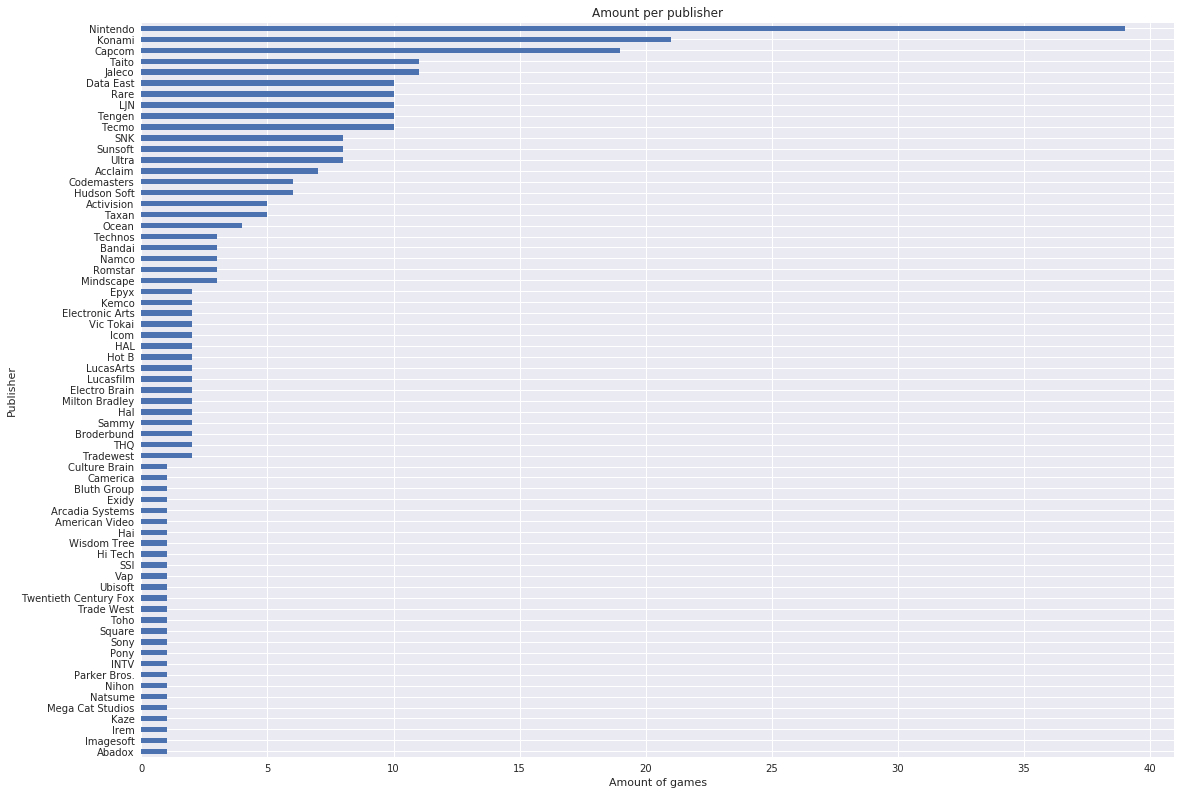

In [209]:
df.groupby('publisher')['name'].count().sort_values(ascending=True).plot.barh(title='Amount per publisher');
plt.ylabel('Publisher');
plt.xlabel('Amount of games');
fig = plt.gcf();
fig.set_size_inches(18.5, 13.5);

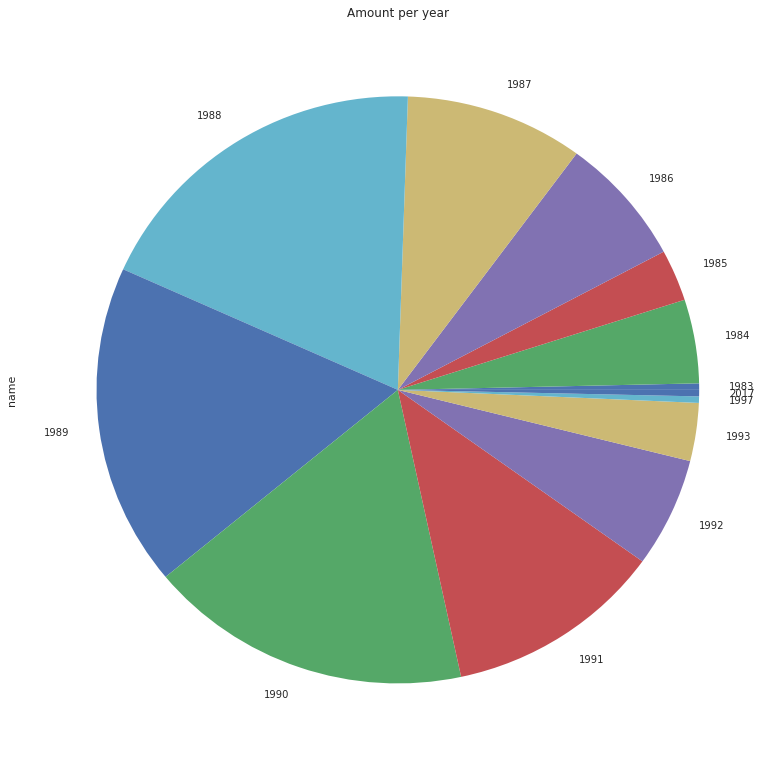

In [207]:
df.groupby('publish_year')['name'].count().plot.pie(title='Amount per year');
fig = plt.gcf();
fig.set_size_inches(13.5, 13.5);

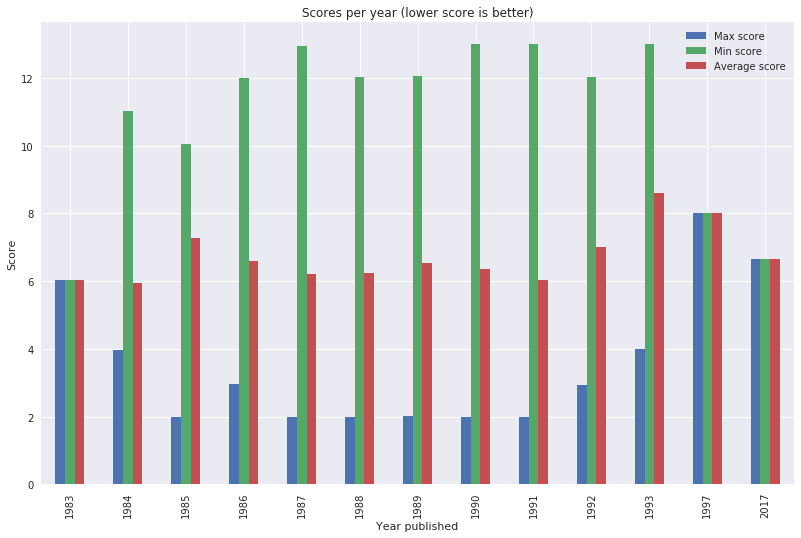

In [208]:
pd.concat(
    [df.groupby('publish_year')['total_grade'].min().rename('Max score'),
     df.groupby('publish_year')['total_grade'].max().rename('Min score'),
     df.groupby('publish_year')['total_grade'].mean().rename('Average score')], axis=1
).plot.bar(title='Scores per year (lower score is better)')
plt.xlabel('Year published');
plt.ylabel('Score');
fig = plt.gcf();
fig.set_size_inches(13.5, 8.5);